# "Full Metadata" Spreadsheet (working title)

See [ticket 576](https://app.zenhub.com/workspaces/dcp-ingest-product-development-5f71ca62a3cb47326bdc1b5c/issues/ebi-ait/dcp-ingest-central/576)

This is an initial attempt for enabling data consumers to explore the metadata of an HCA project with common simple tools with minimal coding such as Excel Pivot Tables.


In [1]:
input_dir= './data'
spreadsheet = f'{input_dir}/ArutyunyanHumanPlacenta_ontologies.xlsx'
output_dir = './examples'
version = '0.7'

In [2]:
import ipywidgets as widgets
from IPython.display import display
report_entity=None
report_entity_dropdown = widgets.Dropdown(
    options=['Sequence file', 'Image file', 'Analysis file'],
    value=report_entity or 'Analysis file',
    description='Report Entity:',
    disabled=False,
)
display(report_entity_dropdown)

Dropdown(description='Report Entity:', index=2, options=('Sequence file', 'Image file', 'Analysis file'), valu…

In [3]:
report_entity = report_entity_dropdown.value

* TODO: skip unnecessary lines
* TODO: natural language column names vs variable names
* DONE: render graph
* DONE: analysis file linking
* DONE: handle CSV fields (separated by ||)
* TODO: analysis file -> imaged specimen <- image file
* TODO: same for analysis file -> cell suspension <- sequence file
* analysis file and image file are n:n relation

Define an Entity Relationship model (entity is a worksheet)

In [4]:
from dataclasses import dataclass

@dataclass
class SequencingProtocol:
    SEQUENCING_PROTOCOL_ID_Required: str
        
@dataclass
class LibraryPreparationProtocol:
    LIBRARY_PREPARATION_PROTOCOL_ID: str

@dataclass
class DissociationProtocol:
    DISSOCIATION_PROTOCOL_ID:str

@dataclass
class CollectionProtocol:
    COLLECTION_PROTOCOL_ID:str

@dataclass
class AnalysisProtocol:
    ANALYSIS_PROTOCOL_ID:str

@dataclass
class DifferentiationProtocol:
    DIFFERENTIATION_PROTOCOL_ID:str
        
@dataclass
class DonorOrganism:
    DONOR_ORGANISM_ID:str 
        
@dataclass
class SpecimenFromOrganism:
    SPECIMEN_FROM_ORGANISM_ID:str
    COLLECTION_PROTOCOL_ID:CollectionProtocol
    INPUT_DONOR_ORGANISM_ID:DonorOrganism
        
@dataclass
class EnrichmentProtocol:
    ENRICHMENT_PROTOCOL_ID:str
            
## CellLine added
@dataclass
class CellLine:
    CELL_LINE_ID: str
    ENRICHMENT_PROTOCOL_ID:EnrichmentProtocol
    DISSOCIATION_PROTOCOL_ID:DissociationProtocol
    INPUT_SPECIMEN_FROM_ORGANISM_ID:SpecimenFromOrganism

## Organoid Added
@dataclass
class Organoid:
    ORGANOID_ID: str
    INPUT_CELL_LINE_ID:CellLine
    INPUT_SPECIMEN_FROM_ORGANISM_ID:SpecimenFromOrganism
    DIFFERENTIATION_PROTOCOL_ID:DifferentiationProtocol

@dataclass
class CellSuspension:
    CELL_SUSPENSION_ID: str
    ENRICHMENT_PROTOCOL_ID:EnrichmentProtocol
    INPUT_SPECIMEN_FROM_ORGANISM_ID:SpecimenFromOrganism
    DISSOCIATION_PROTOCOL_ID:DissociationProtocol
    INPUT_SPECIMEN_FROM_ORGANISM_ID:SpecimenFromOrganism
    INPUT_ORGANOID_ID:Organoid
    INPUT_CELL_LINE_ID:CellLine
    
@dataclass
class SequenceFile:
    SEQUENCING_PROTOCOL_ID_Required: SequencingProtocol
    LIBRARY_PREPARATION_PROTOCOL_ID_Required: LibraryPreparationProtocol
    INPUT_CELL_SUSPENSION_ID_Required: CellSuspension

        
@dataclass
class ImagingPreparationProtocol:
    IMAGING_PREPARATION_PROTOCOL_ID:str

        
@dataclass
class ImagedSpecimen:
    IMAGED_SPECIMEN_ID_Required:str
    INPUT_SPECIMEN_FROM_ORGANISM_ID_Required:SpecimenFromOrganism
    IMAGING_PREPARATION_PROTOCOL_ID_Required:ImagingPreparationProtocol


@dataclass
class AnalysisFile:
    ANALYSIS_PROTOCOL_ID_Required: AnalysisProtocol
    IMAGED_SPECIMEN_ID_Required:ImagedSpecimen
    CELL_SUSPENSION_ID_Required:CellSuspension
    LIBRARY_PREPARATION_PROTOCOL_ID_Required:LibraryPreparationProtocol
    SEQUENCING_PROTOCOL_ID_Required:SequencingProtocol

        
@dataclass
class ImagingProtocol:
    IMAGING_PROTOCOL_ID:str

        
@dataclass
class ImageFile:
    INPUT_IMAGED_SPECIMEN_ID:ImagedSpecimen
    IMAGING_PROTOCOL_ID:ImagingProtocol


/var/folders/cg/kjj0b2v92rx2c4s4d0wc5by80000gp/T/ipykernel_39493/2241606415.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


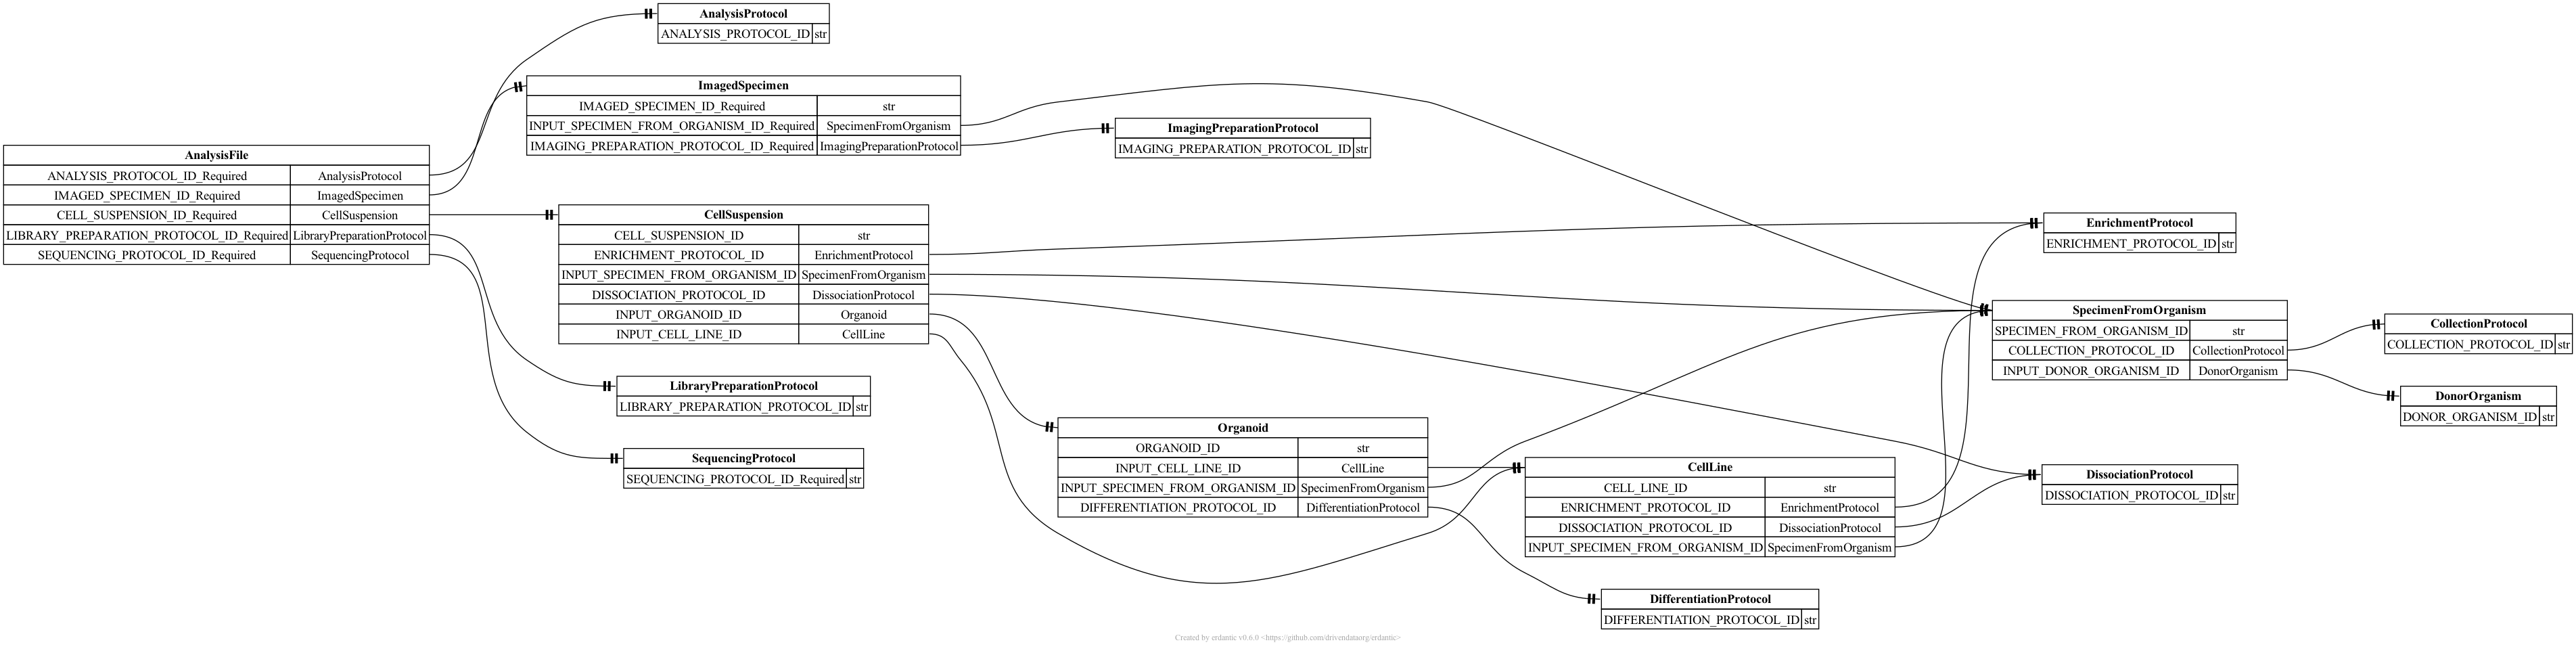

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import erdantic as erd
diagram = erd.create(AnalysisFile)
diagram

In [6]:
@dataclass
class Link:
    source:str
    target:str
    source_field:str
    target_field:str = None
    join_type:str = 'left'
    
        
    def __post_init__(self):
        if self.target_field is None:
            self.target_field = self.source_field
        else:
            print(f'{self.source}->{self.target} using fields {self.source_field}->{self.target_field}')
        
# TODO: links list is assumed to be topologically sorted, in the future - sort
links = [
#     Link('Image file', 'Imaged specimen', 'INPUT IMAGED SPECIMEN ID (Required)', 'IMAGED SPECIMEN ID (Required)'),
#     Link('Image file', 'Imaging protocol', 'IMAGING PROTOCOL ID (Required)'),
#     Link('Imaged specimen', 'Specimen from organism', 'INPUT SPECIMEN FROM ORGANISM ID (Required)', 'SPECIMEN FROM ORGANISM ID (Required)'),
#     Link('Imaged specimen', 'Imaging preparation protocol', 'IMAGING PREPARATION PROTOCOL ID (Required)'),

#     Link('Sequence file', 'Sequencing protocol', 'SEQUENCING PROTOCOL ID (Required)'),
#     Link('Sequence file','Library preparation protocol', 'LIBRARY PREPARATION PROTOCOL ID (Required)'),
#    Link('Sequence file', 'Cell suspension', 'INPUT CELL SUSPENSION ID (Required)','CELL SUSPENSION ID (Required)'),

    Link('Analysis file', 'Analysis protocol', 'ANALYSIS PROTOCOL ID (Required)', 'ANALYSIS PROTOCOL ID'),
    Link('Analysis file', 'Cell suspension', 'CELL SUSPENSION ID (Required)'),
    Link('Analysis file', 'Library preparation protocol', 'LIBRARY PREPARATION PROTOCOL ID (Required)'),
    Link('Analysis file', 'Sequencing protocol', 'SEQUENCING PROTOCOL ID (Required)'),
    
    Link('Cell suspension', 'Enrichment protocol','ENRICHMENT PROTOCOL ID (Required)'),
    Link('Cell suspension', 'Specimen from organism','INPUT SPECIMEN FROM ORGANISM ID (Required)','SPECIMEN FROM ORGANISM ID (Required)'),
    Link('Cell suspension', 'Dissociation protocol','DISSOCIATION PROTOCOL ID (Required)'),
    
    Link('Cell suspension', 'Organoid','INPUT ORGANOID ID (Required)','ORGANOID ID (Required)'),

    Link('Organoid', 'Cell line','INPUT CELL LINE ID (Required)','CELL LINE ID (Required)'),
    Link('Organoid', 'Differentiation protocol','DIFFERENTIATION PROTOCOL ID (Required)', 'DIFFERENTIATION PROTOCOL ID (Required)'),
    Link('Organoid', 'Specimen from organism','INPUT SPECIMEN FROM ORGANISM ID (Required)','SPECIMEN FROM ORGANISM ID (Required)'),
    
    Link('Cell line', 'Specimen from organism','INPUT SPECIMEN FROM ORGANISM ID (Required)','SPECIMEN FROM ORGANISM ID (Required)'),
    Link('Cell line', 'Enrichment protocol','ENRICHMENT PROTOCOL ID (Required)'),
    Link('Cell line', 'Dissociation protocol','DISSOCIATION PROTOCOL ID (Required)'),


    Link('Specimen from organism', 'Collection protocol', 'COLLECTION PROTOCOL ID (Required)'),
    Link('Specimen from organism', 'Donor organism','INPUT DONOR ORGANISM ID (Required)','DONOR ORGANISM ID (Required)'),

    
#     Link('Analysis file', 'Imaged specimen', 'IMAGED SPECIMEN ID (Required)'),    
#     Link('Imaged specimen', 'Analysis file', 'IMAGED SPECIMEN ID (Required)', join_type='left')
    
]



Analysis file->Analysis protocol using fields ANALYSIS PROTOCOL ID (Required)->ANALYSIS PROTOCOL ID
Cell suspension->Specimen from organism using fields INPUT SPECIMEN FROM ORGANISM ID (Required)->SPECIMEN FROM ORGANISM ID (Required)
Cell suspension->Organoid using fields INPUT ORGANOID ID (Required)->ORGANOID ID (Required)
Organoid->Cell line using fields INPUT CELL LINE ID (Required)->CELL LINE ID (Required)
Organoid->Differentiation protocol using fields DIFFERENTIATION PROTOCOL ID (Required)->DIFFERENTIATION PROTOCOL ID (Required)
Organoid->Specimen from organism using fields INPUT SPECIMEN FROM ORGANISM ID (Required)->SPECIMEN FROM ORGANISM ID (Required)
Cell line->Specimen from organism using fields INPUT SPECIMEN FROM ORGANISM ID (Required)->SPECIMEN FROM ORGANISM ID (Required)
Specimen from organism->Donor organism using fields INPUT DONOR ORGANISM ID (Required)->DONOR ORGANISM ID (Required)


/Users/arsenios/miniconda3/envs/amnon_flat/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


{('Analysis file',
  'Analysis protocol'): Text(0.25772881166438005, -0.6705188405731634, 'ANALYSIS PROTOCOL ID (Required)\n->ANALYSIS PROTOCOL ID'),
 ('Analysis file',
  'Cell suspension'): Text(-0.03822331151126516, -0.26234799365270894, 'CELL SUSPENSION ID (Required)\n->CELL SUSPENSION ID (Required)'),
 ('Analysis file',
  'Library preparation protocol'): Text(0.14015274290974739, -0.7820313267829531, 'LIBRARY PREPARATION PROTOCOL ID (Required)\n->LIBRARY PREPARATION PROTOCOL ID (Required)'),
 ('Analysis file',
  'Sequencing protocol'): Text(-0.03575864276223215, -0.75519455028832, 'SEQUENCING PROTOCOL ID (Required)\n->SEQUENCING PROTOCOL ID (Required)'),
 ('Cell suspension',
  'Enrichment protocol'): Text(-0.3081887990497002, 0.0879733967446143, 'ENRICHMENT PROTOCOL ID (Required)\n->ENRICHMENT PROTOCOL ID (Required)'),
 ('Cell suspension',
  'Specimen from organism'): Text(-0.011206239027624479, 0.188638924567081, 'INPUT SPECIMEN FROM ORGANISM ID (Required)\n->SPECIMEN FROM ORGANIS

<Figure size 640x480 with 0 Axes>

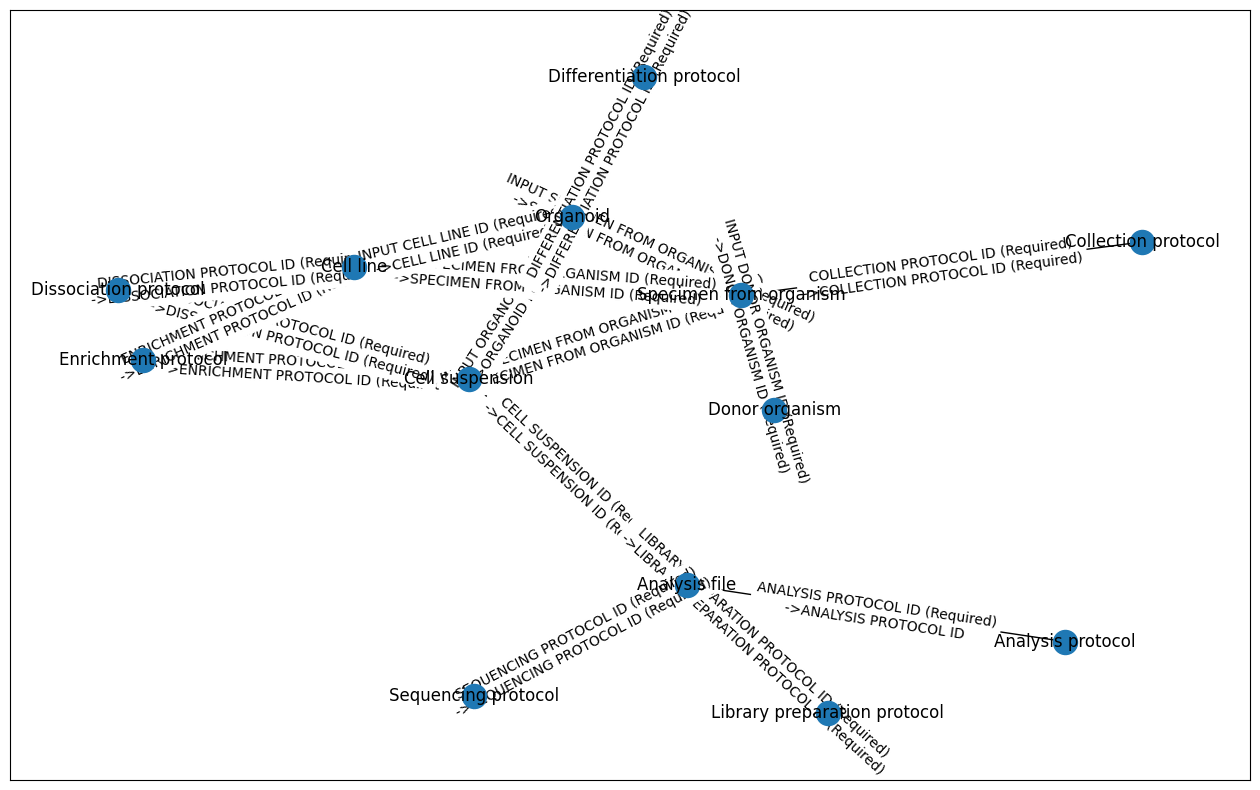

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from functools import partial


%matplotlib inline


def add_link_to_graph(graph :nx.Graph, link :Link):
    map(graph.add_node, filter(lambda node:node not in graph.nodes, [link.source, link.target] ))
    graph.add_edge(link.source, link.target, keys=f'{link.source_field}\n->{link.target_field}')

G = nx.Graph()
x =list(map(partial(add_link_to_graph, G), links))

fig = plt.figure()
plt.figure(figsize=(16, 10))

labels = nx.get_edge_attributes(G, 'keys')
pos = nx.spring_layout(G)          
nx.draw_networkx(G, pos, arrowstyle="->",)
nx.draw_networkx_edge_labels(G, pos, labels, font_size=10)


In [8]:
import pandas as pd
sep='\|\|'
def explode_csv_col(df :pd.DataFrame, column :str, sep=',') -> pd.DataFrame:
    cols={}
    cols[column] = df[column].str.split(sep)
    return df.assign(**cols).explode(column)

def format_column_name(column_name, namespace):
    return f'{namespace}_{column_name}'

def prefix_columns(df, prefix):
    return df.rename(columns=lambda c:format_column_name(namespace=prefix,column_name=c))

first_data_line=4
def remove_field_desc_lines(df:pd.DataFrame) -> pd.DataFrame:
    return df[first_data_line:]

In [9]:
from datetime import datetime
now = lambda : datetime.now().strftime('%H%M%S.%f')

import os
def join_worksheet(worksheet:pd.DataFrame, 
                   link:Link, 
                   spreadsheet:str) -> pd.DataFrame:
    print(f'joining [{link.source}] to [{link.target}]')
    print(f'fields [{link.source_field}] and [{link.target_field}]')
    try:
        source_field = format_column_name(column_name=link.source_field, namespace=link.source)
        target_field = format_column_name(column_name=link.target_field, namespace=link.target)
        worksheet = explode_csv_col(df=worksheet, column=source_field, sep=sep)
 
        spreadsheet_obj = pd.ExcelFile(spreadsheet)
        if link.target not in spreadsheet_obj.sheet_names:
            raise ValueError(f'spreadsheet does not contain {link.target} sheet. Possible names {sorted(spreadsheet_obj.sheet_names)}')
        target = spreadsheet_obj.parse(link.target)

        target = pd.read_excel(spreadsheet, link.target)
        target = remove_field_desc_lines(target)
        target = prefix_columns(target, prefix=link.target)

        target = explode_csv_col(target, column=target_field, sep=sep)

        if target_field in worksheet.columns:
            result = worksheet.merge(target, 
                                     how=link.join_type, 
                                     left_on=source_field, 
                                     right_on=target_field,
                                     suffixes=(None, '_y'))
            duplicated_cols = [col for col in result.columns if col.endswith('_y')]
            overwritting_cols = [x.strip('_y') for x in duplicated_cols]
            # exclude case a field is derived from different tabs
            # (i.e. one cell suspension from organoid AND specimen)
            # for selected columns, values should either everything na, or None or _y should be na
            result_na_none = result[overwritting_cols].dropna(how='all')
            result_na_y = result[duplicated_cols].dropna(how='all')
            if not result_na_y.index.intersection(result_na_none.index).empty:
                print(f'Multiple {link.target} for the same element. Will skip {link.target} from {link.source}')
                result = result.drop(columns=duplicated_cols)
            else:
                # copy values from duplicated columns to the na of the previously filled columns
                result = result.drop(columns=duplicated_cols).fillna(result_na_y.rename(columns = lambda x: x.strip('_y')))
                result.drop(columns=source_field, inplace= True)

        else:
            result = worksheet.merge(target, 
                                    how=link.join_type, 
                                    left_on=source_field, 
                                    right_on=target_field)
            result.drop(columns=source_field, inplace= True)
        print(f'record count: original {len(worksheet)}, joined {len(result)}')
        if len(result.index) == 0:
            raise RuntimeError('problem joining [{link.source}] to [{link.target}] using fields [{source_field}] and [{target_field}]: join resulted in zero rows')
        
    except KeyError as e:
        err_msg = f'problem joining [{link.source}] to [{link.target}] using fields [{source_field}] and [{target_field}]: {e}'
        raise RuntimeError(err_msg) from e
    return result

In [10]:
import pandas as pd
from collections import namedtuple
from functools import partial, reduce

def flatten_spreadsheet(spreadsheet, report_entity):
    spreadsheet_obj = pd.ExcelFile(spreadsheet)
    if report_entity not in spreadsheet_obj.sheet_names:
        raise ValueError(f'spreadsheet does not contain {report_entity} sheet')
    report_sheet = spreadsheet_obj.parse(report_entity)
    report_sheet = prefix_columns(report_sheet, prefix=report_entity)
    report_sheet = remove_field_desc_lines(report_sheet)
    flattened = reduce(partial(join_worksheet, spreadsheet=spreadsheet), 
                       links,
                       report_sheet)
    return flattened

flattened = flatten_spreadsheet(spreadsheet, report_entity)

# remove empty columns
flattened.dropna(axis='columns',how='all', inplace=True)

# add project label
project_info = pd.read_excel(spreadsheet, 'Project')
data_row_idx = 4
project_label = project_info['PROJECT LABEL (Required)'][data_row_idx]
flattened['project_label'] = project_label

# use ingest attribute names as columns
spreadsheet_obj = pd.ExcelFile(spreadsheet)
for column in flattened.columns:
    tab, original_column = column.split('_')
    if tab not in spreadsheet_obj.sheet_names:
        continue
    tab_df = spreadsheet_obj.parse(tab)
    data_row_idx = 2
    ingest_attribute_name = tab_df[original_column][data_row_idx]
    if ingest_attribute_name not in flattened.columns:
        flattened.rename(columns={column:ingest_attribute_name}, inplace=True)
    else:
        flattened.drop(labels=column, axis='columns', inplace=True)


joining [Analysis file] to [Analysis protocol]
fields [ANALYSIS PROTOCOL ID (Required)] and [ANALYSIS PROTOCOL ID]
record count: original 163, joined 163
joining [Analysis file] to [Cell suspension]
fields [CELL SUSPENSION ID (Required)] and [CELL SUSPENSION ID (Required)]
record count: original 522, joined 522
joining [Analysis file] to [Library preparation protocol]
fields [LIBRARY PREPARATION PROTOCOL ID (Required)] and [LIBRARY PREPARATION PROTOCOL ID (Required)]
record count: original 1822, joined 1822
joining [Analysis file] to [Sequencing protocol]
fields [SEQUENCING PROTOCOL ID (Required)] and [SEQUENCING PROTOCOL ID (Required)]
record count: original 3492, joined 3492
joining [Cell suspension] to [Enrichment protocol]
fields [ENRICHMENT PROTOCOL ID (Required)] and [ENRICHMENT PROTOCOL ID (Required)]
record count: original 6742, joined 6742
joining [Cell suspension] to [Specimen from organism]
fields [INPUT SPECIMEN FROM ORGANISM ID (Required)] and [SPECIMEN FROM ORGANISM ID (R

In [11]:
from os.path import basename, splitext
report_entity_clean = report_entity.replace(" ","-")
flattened_filename = f'{output_dir}/{splitext(basename(spreadsheet))[0]}_denormalised_{report_entity_clean}_v{version}.xlsx'
flattened.to_excel(flattened_filename)

In [12]:
import openpyxl
import getpass
fh = openpyxl.load_workbook(flattened_filename)

obj = fh.properties   

fh.properties.title = f'denormalised hca metadata for project {project_label} showing {report_entity}'
fh.properties.version = version
fh.properties.keywords = f'flattened,hca,metadata,{project_label},{report_entity_clean}'
fh.properties.creator = getpass.getuser( )
fh.properties.lastModifiedBy = getpass.getuser( )
fh.properties.created=datetime.now()
fh.properties.modified=datetime.now()


fh.save(flattened_filename)

In [13]:
flattened.head()

,analysis_file.file_core.file_name,analysis_file.file_core.format,analysis_file.file_core.content_description.text,analysis_file.file_core.content_description.ontology,analysis_file.file_core.content_description.ontology_label,analysis_file.file_core.file_source,analysis_file.matrix_cell_count,analysis_file.genome_assembly_version,imaged_specimen.biomaterial_core.biomaterial_id,process.process_core.process_id,...,donor_organism.diseases.ontology,donor_organism.diseases.ontology_label,donor_organism.death.cause_of_death,donor_organism.gestational_age,donor_organism.gestational_age_unit.text,donor_organism.gestational_age_unit.ontology,donor_organism.gestational_age_unit.ontology_label,donor_organism.familial_relationships.child,donor_organism.familial_relationships.parent,project_label
0,adata_all_donors_all_cell_states_raw_counts_in...,h5ad,Count matrix,data:3917,Count matrix,Publication,325665,GRCh38,NaN,NaN,...,PATO:0000461,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ArutyunyanHumanPlacenta
1,adata_all_donors_all_cell_states_raw_counts_in...,h5ad,Count matrix,data:3917,Count matrix,Publication,325665,GRCh38,NaN,NaN,...,PATO:0000461,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ArutyunyanHumanPlacenta
2,adata_all_donors_all_cell_states_raw_counts_in...,h5ad,Count matrix,data:3917,Count matrix,Publication,325665,GRCh38,NaN,NaN,...,PATO:0000461,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ArutyunyanHumanPlacenta
3,adata_all_donors_all_cell_states_raw_counts_in...,h5ad,Count matrix,data:3917,Count matrix,Publication,325665,GRCh38,NaN,NaN,...,PATO:0000461,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ArutyunyanHumanPlacenta
4,adata_all_donors_all_cell_states_raw_counts_in...,h5ad,Count matrix,data:3917,Count matrix,Publication,325665,GRCh38,NaN,NaN,...,PATO:0000461,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ArutyunyanHumanPlacenta


# normalise a flattened spreadsheet and recover original

In [ ]:
from openpyxl import Workbook

fqn_separator = '.'

df_by_sheet = {}

wb = Workbook()
for col in flattened.columns:
    if col.startswith('project'):
        sheet_name = 'project'
    else:
        try:
            sheet_name, fq_name = col.split(fqn_separator, maxsplit=1)
        except ValueError as e:
            print(f'problem converting col name: {col}: {e}')
        
    if sheet_name not in df_by_sheet:
        df_by_sheet[sheet_name]=pd.DataFrame()
    sheet_df = df_by_sheet[sheet_name]
    try:
        sheet_df.insert(loc=0,
                        column=col, 
                        value=flattened[col])
    except ValueError as e:
        print(f'problem importing column data: {col}: {e}')
        print(flattened[col].head())
        break

dest_filename = f'{output_dir}/reconstructed.xlsx'
with pd.ExcelWriter(dest_filename) as xl_writer:  
    for sheet_name, sheet_df in df_by_sheet.items():
        sheet_df.drop_duplicates(inplace=True)
        sheet_df.to_excel(xl_writer, sheet_name=sheet_name)
                          
for sheet_name, sheet_df in df_by_sheet.items():                          
    original_sheet_name = sheet_name[0].upper()+sheet_name[1:].replace('_', ' ')
    original_sheet = pd.read_excel(spreadsheet, original_sheet_name)
    print(f'{sheet_name}: rows {len(sheet_df)}, original: {original_sheet_name}, {len(original_sheet)}')
